<a href="https://colab.research.google.com/github/sanjabh11/Projects/blob/master/IBM_Complaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Complaints

In [0]:
#https://github.com/IBM/support-ticket-classification/tree/master/docs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
! curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   4938      0 --:--:-- --:--:-- --:--:--  4938
Updating fastai...
Done.


In [0]:
import fastai
fastai.__version__

'1.0.49'

In [0]:
from fastai.text import *

In [0]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [0]:
path = "/content"

It only contains one csv file, let's have a look at it.

In [0]:
df = pd.read_csv('consumercomp.csv')
df.head()

,label,text,is_valid
0,Bank,I had recently received a check for a settleme...,False
1,Bank,"At Bank Of America, I have had my personal & b...",False
2,Bank,"I Bank with Wells fargo, I went in to deposit ...",False
3,Bank,Charges for my purchases were shown pending on...,False
4,Bank,I made purchases after my direct deposit was m...,False


It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [0]:
#data_lm = TextDataBunch.from_csv(path, 'az_tickets.csv')
data_lm = TextLMDataBunch.from_csv(path,'consumercomp.csv')


In [0]:
data_lm.save()

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [0]:
#Free GPU memory
del learn
gc.collect()

7454

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=URLs.WT103, drop_mult=0.3)


In [0]:
bs=48

In [0]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


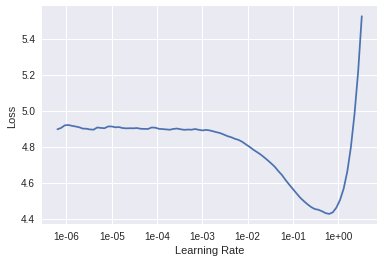

In [0]:
learn.recorder.plot()


In [0]:
learn.fit_one_cycle(30, max_lr = slice(1e-03, 8e-01), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.373552,3.927270,0.239063,00:04
1,3.916189,4.066265,0.229539,00:04
2,3.779650,4.545204,0.194345,00:04
3,4.000236,5.264349,0.159003,00:04
4,4.521929,6.062924,0.121354,00:04
5,5.177174,6.594183,0.095759,00:04
6,5.883930,8.383740,0.066964,00:04
7,6.861888,8.643205,0.072619,00:04
8,7.425209,7.764313,0.092783,00:04
9,7.743027,7.501230,0.091592,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


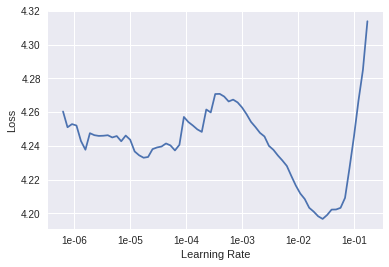

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(10, max_lr = slice(1e-03, 4e-02), moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,2.011467,6.070219,0.181324,00:05
1,1.989914,6.219534,0.170312,00:05
2,2.055348,5.961630,0.186310,00:05
3,2.055552,6.205362,0.181176,00:05
4,1.978391,6.416491,0.175074,00:05


KeyboardInterrupt: ignored

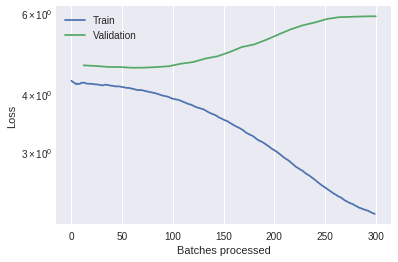

In [0]:
learn.recorder.plot_losses()
plt.yscale('log')

In [0]:
learn.save_encoder('fine_tuned_enc')


In [0]:
learn.load_encoder('fine_tuned_enc')



In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(10, slice(1e-03/(2.6**4),1e-03), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,1.992180,5.893211,0.184747,00:04
1,1.976841,5.905148,0.184896,00:04
2,1.979869,5.926122,0.184896,00:04
3,1.983948,5.925508,0.182589,00:04
4,1.986416,5.940693,0.182812,00:04
5,1.976138,5.948131,0.183185,00:04
6,1.971247,5.957194,0.182515,00:04
7,1.965459,5.960056,0.184375,00:04
8,1.971418,5.959633,0.183631,00:04
9,1.977391,5.952474,0.183408,00:04


In [0]:
learn.freeze_to(-3)

learn.fit_one_cycle(10, slice(5e-03/(2.6**4),5e-03), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.966121,6.031909,0.179911,00:04
1,1.957184,6.039249,0.183631,00:04
2,1.939524,6.055952,0.182366,00:04


In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(5e-04/(2.6**4),5e-04), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.932006,6.050814,0.183631,00:05
1,1.964219,6.044617,0.180580,00:05
2,1.942088,6.053196,0.181920,00:05
3,1.944440,6.051639,0.182961,00:05
4,1.925392,6.073980,0.183333,00:05
5,1.911190,6.079351,0.182515,00:05
6,1.901632,6.090040,0.181696,00:05
7,1.896877,6.089537,0.181548,00:05
8,1.896201,6.080956,0.181473,00:05
9,1.900990,6.093023,0.180804,00:05


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
!cp /content/data_clas.pkl '/drive/My Drive/models/'

In [0]:
!cp '/drive/My Drive/models/fine_tuned_enc.pth' models

In [0]:
#learn = text_classifier_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')



3. Text classification

In [0]:
data = (TextList.from_csv(path, 'az_tickets.csv', cols='Description')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())
data_clas.show_batch(1)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [0]:
data = TextClasDataBunch.from_csv(path, 'complaints.csv')
data.show_batch()

text,target
xxbos xxup we xxup were xxup working xxup with xxup an xxup attorney xxup to xxup try xxup and xxup get a xxup modification xxup on xxup our xxup home xxup loan xxup with xxup bank xxup of xxup america xxup for xxup over 3 xxup years xxup and xxup then xxup they xxup all xxup of a xxup sudden xxup they xxup decided xxup to xxup foreclose xxup on,mortgage
"xxbos i xxup received a xxup notice xxup by xxup mail , xxup according xxup to xxup them xxup is xxup the xxup second xxup notice , xxup for xxup me xxup is xxup the xxup first xxup one xxup that i xxup received , xxup about a xxup medical xxup bill xxup that xxup was xxup unpaid xxup from 2012 , xxup this xxup is xxup the xxup first",Medical
"xxbos i xxup paid xxup my xxup mortgage xxup in xxup the xxup usual xxup fashion xxup as xxup always xxup on xxup line , , , xxup this xxup month xxup for xxup some xxup reason xxup all xxup payments xxup came xxup in xxup together xxup and xxup ocwen xxup xxunk xxup get xxup their xxup payment .. xxup to xxup avoid xxup confusion i xxup put xxup",mortgage
xxbos xxup collection xxup center xxup is a xxup company xxup that i xxup have xxup never xxup conducted xxup business xxup with . xxup they xxup are xxup reporting xxup that i xxup owe xxup medical xxup bills xxup to xxup them . xxup my xxup medical xxup bills xxup have xxup been xxup paid xxup by xxup the xxup united xxup states xxup government xxup for,Medical
"xxbos xxmaj chase xxmaj bank violated 18 xxup xxunk s 1341 , xxup united xxup states xxup code xxup title 18 . xxup crimes xxup and xxup criminal xxup procedure xxup part i - xxup crimes , xxup chapter xxup xxunk xxup fraud , xxup section 1341 . xxmaj frauds and xxunk , . \r \n \r \n i. xxmaj banks knowing and",Loan


In [0]:
data.train_ds.x.items, data.train_ds.y.items

(array([array([   2,    5,  237,   73,   10,  190,    5,  610,   13,  520,   12,  147,   15,   34,   45,   16,   20,  133,
          24,  752,   26,   12,  147,   15,   45,    9,    5,  329,   17,   94, 1400,  254,   26,   27,   11,   91,
          22,  650, 3477,   17,   73,  265,   11,  227, 4460]),
        array([   2,   10,   21,   44,  123,   12,  103,    6, 1672,  273,  118,   12,  304,   15,    6,  352,   27,   15,
          34,  355,   97,   96,   11,  203,  208,   90,   13,  237,   73,   20,  356,   26,  289, 1401,  435,   20,
          54,  467,   12,  304,   32,    9,  113,   10,  257,   14, 2966]),
        array([   2,  596,   11,   30,   22, 3210,   27,   11, 1736,   13,  175,   12,  139,  212,  238,   18,  169,   27,
          11,  179,   30,    9]),
        array([   2,    5, 1069,    5, 1498,    5,  528,   40,  770,  178, 2765,   27,   15,   31,   49,    9,   10,   21,
          58,   63,   73,   21,   41,   85,  311,   29,   43,   13,   10,   21,   24,   52,   85,  313

In [0]:
len(data.train_ds), len(data.valid_ds)

(21228, 5308)

In [0]:
#interp = ClassificationInterpretation.from_learner(learn)


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [0]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [0]:
data.train_ds[10][0], data.valid_ds[10][0]

(Text xxbos credit card that i did not apply for . i disputed the inquiries and go a same old letter stating the,
 Text xxbos . i say what and she states a woman on the other line mentioned it to her . i was xxunk that any possible debt was)

But the underlying data is all numbers

In [0]:
data.train_ds[10][0].data[:10]

array([  2,  31, 100,  19,  10,  60,  24, 602,  22,   9])

In [0]:
learn.data.valid_ds.y, learn.data.train_ds.x

(LMLabelList (5308 items)
 ,,,,
 Path: /content, LMTextList (21228 items)
 xxbos i keep getting calls and voice mails about a payday loan that my daughter owes . i ' m not a co - signer and i ' ve asked the company to stop calling me and leaving threatening voicemails for her . xxmaj about a,xxbos . i was told at the time of the sale by the dealer and the finance company told me the same thing that i could refinance after 12 months of paying my payment on time .,xxbos she started the call by talking about my son and his birthday and the age he is not introducing her self or the co,xxbos xxmaj this letter is being sent to you in response your erroneous reporting to the xxmaj credit xxmaj bureau { s } , the highly negative impact on my personal credit report . xxmaj please be advised that this is not a refusal,xxbos , 2015 i was told to send them documentation t
 Path: /content)

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [0]:
df.head()

,label,text
0,Medical,My identity was stolen and used. I want this r...
1,Medical,and found an open account for americollect
2,mortgage,"and a mortgage company, The Money Source. I h..."
3,money transfer,SunTrust Bank received a wire transfer paymen...
4,Medical,", 2019, stating that there had been some chang..."


In [0]:
#https://docs.fast.ai/tutorial.data.html
data_clas = (TextList.from_csv(path, 'complaints.csv', cols='text', vocab=data_lm.vocab) 
             .split_from_df(col='is_valid') 
             .label_from_df(cols='label') 
             .databunch(bs=42))

In [0]:
#data = (TextLMDataBunch.from_csv(path,'az_tickets.csv')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

In [0]:
data.save('data_clas.pkl')

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
bs=24

Now let's grab the full dataset for what follows.

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [0]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))


In [0]:
data_lm = (TextLMDataBunch.from_csv(path, 'complaints.csv', vocab=data_lm.vocab) 
             .split_from_df(col='is_valid') 
             .label_from_df(cols='label') 
             .databunch(bs=24))

In [0]:
Factory methods (TextDataBunch)
from_csv(path, csv_name, valid_pct:float=0.2, test:Optional[str]=None, 
         tokenizer:Tokenizer=None, vocab:Vocab=None, classes:StrList=None, 
         delimiter:str=None, header='infer', text_cols:IntsOrStrs=1, 
         label_cols:IntsOrStrs=0, label_delim:str=None, chunksize:int=10000, 
         max_vocab:int=60000, min_freq:int=2, mark_fields:bool=False, 
         include_bos:bool=True, include_eos:bool=False, **kwargs) 

In [0]:
#try latest
data_lm = (TextDataBunch.from_csv(path, csv_name, valid_pct=0.2, 
           test=None, vocab=data_lm.vocab)

In [0]:
#modify to TextList to avoid junk in remove cols='Description',
data_lm = (TextList.from_csv(path, 'az_tickets.csv', vocab=data_lm.vocab) 
             .split_from_df(col='is_valid') 
             .label_from_df(cols='label') 
             .databunch(bs=42))

In [0]:
data_lm.save('data_lm.pkl')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
data.show_batch()

text,target
xxbos xxup we xxup were xxup working xxup with xxup an xxup attorney xxup to xxup try xxup and xxup get a xxup modification xxup on xxup our xxup home xxup loan xxup with xxup bank xxup of xxup america xxup for xxup over 3 xxup years xxup and xxup then xxup they xxup all xxup of a xxup sudden xxup they xxup decided xxup to xxup foreclose xxup on,mortgage
xxbos i xxup have xxup had xxup numerous xxup calls xxup from xxup portfolio xxup recovery xxup on a xxup debt xxup that i xxup am xxup not xxup sure i xxup owe . xxup when xxup asked xxup multiple xxup times xxup to xxup send xxup me xxup in xxup writing xxup the xxup original xxup facts xxup they xxup refuse xxup and xxup threaten xxup me xxup with,Credit card
"xxbos xxup attn xxup cfpb xxup this xxup is xxup not a xxup duplicate xxup complaint , xxup this xxup is xxup in xxup response xxup to a xxup letter xxup that i xxup recieved xxup in xxup the xxup mail xxup from xxup bc xxup services . xxup as xxup bc xxup services xxup is xxup no xxup doubt xxup aware xxup that xxup they xxup are xxup currently",Medical
"xxbos i xxup have xxup applied xxup for xxup hardship xxup assistance xxup with xxup my xxup servicer xxup sps "" xxup select xxup portfolio xxup servicing '' xxup and xxup was xxup recently xxup denied xxup due xxup to xxup it xxup is xxup not xxup in xxup the xxup financial xxup interest xxup of xxup the xxup investor xxup of xxup my xxup loan . i xxup want",mortgage
"xxbos xxup ocwen xxup loan xxup servicing xxup xxunk xxup my xxup home xxup loan , xxup first xxup and xxup second xxup several xxup times xxup over a xxup two xxup year xxup period . xxup my xxup debt xxup balance xxup was xxup partially xxup forgiven xxup in xxup xxunk xxup with xxup the xxup imposed xxup xxunk xxup against xxup ocwen . xxup today",mortgage


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [0]:
del learn
gc.collect()

7271

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


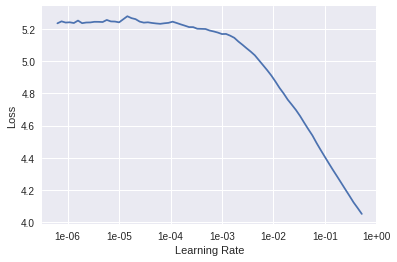

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, slice(1e-03, 9e-01), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.685722,2.290067,0.513247,01:30


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.164634,2.062495,0.520555,01:47
1,2.030555,1.952735,0.532548,01:46
2,1.994186,1.937293,0.533409,01:46


In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "printer not"
N_WORDS = 100
N_SENTENCES = 5
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

printer not 9 5 20 21 24 53 11 5 50 5 0 5 120 5 20 ] xxbos [ 2 22 38 0 5 23 37 40 14 30 19 10 64 53 11 6 18 6 64 6 36 16 6 6 31 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 36 6 60 6 6 6 6 6 6 6 6 11 6 6 6 6 24 6 6 6 6 6 6 6 11 6 6 6 6 6 60 6 17 6 ] xxbos
printer not 22 15 31 49 16 10 21 64 41 0 ] xxbos [ 2 5 15 37 5 0 16 72 28 11 50 36 5 49 9 5 45 41 100 15 31 49 16 11 36 18 77 19 11 30 19 20 24 ] xxbos [ 2 10 75 95 14 5 120 5 36 5 50 5 0 16 5 0 ] xxbos [ 2 9 5 20 21 24 53 29 14 50 36 9 10 18 80 14 31 90 5 60 9 10 41 12 15 38 ] xxbos [ 2 5 11
printer not 13 20 21 24 95 22 0 ] xxbos [ 2 5 11 5 60 9 5 45 41 12 201 14 31 9 5 20 21 24 12 23 36 31 13 26 18 24 24 ] xxbos [ 2 10 21 14 ... 29 5 0 5 0 25 16 5 31 5 60 17 5 0 5 37 5 50 5 50 5 49 6 0 16 12 14 5 35 22 10 21 100 14 5 0 ] xxbos [ 2 5 45 21 14 50 36 5 120 5 0 5 37 5 50 5
printer not 12 5 50 5 31 5 36 28 24 90 27 15 49 11 31 49 27 15 31 49 9 10 21 ] xxbos [ 2 16 5 50 5 0 5 50 5 37 5 60 17 5 60 9 5 45 21 14 ... 29 6 36 6 0 ] xxbos [ 2 5 2

We not only have to save the model, but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
df.head()

,label,text,is_valid
0,Medical,My identity was stolen and used. I want this r...,False
1,Medical,and found an open account for americollect,False
2,mortgage,"and a mortgage company, The Money Source. I h...",False
3,money transfer,SunTrust Bank received a wire transfer paymen...,False
4,Medical,", 2019, stating that there had been some chang...",False


In [0]:
del learn
gc.collect()

7759

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = (TextList.from_csv(path,'complaints.csv', cols='text', 
                vocab=data_lm.vocab)
                .split_from_df(col='is_valid') 
                .label_from_df(cols='label')
                .databunch(bs=bs))
data_clas.save('data_clas.pkl')

In [0]:
#
data_clas = ( TextDataBunch.from_csv(path, 'az_tickets.csv', vocab=data_lm.vocab) 
             .split_from_df(col='is_valid') 
             .label_from_df(cols='label') 
             .databunch(bs=64))
data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.train_ds.y.c2i

{'Credit card': 0,
 'Credit card ': 1,
 'Loan': 2,
 'Medical': 3,
 'Mobile or digital wallet': 4,
 'Payday loan': 5,
 'Virtual currency': 6,
 'money transfer': 7,
 'mortgage': 8}

In [0]:
data_clas.train_ds.y.items

array([3, 3, 8, 7, ..., 1, 8, 8, 8])

In [0]:
data_clas.show_batch()

text,target
xxbos xxup we xxup were xxup working xxup with xxup an xxup attorney xxup to xxup try xxup and xxup get a xxup modification xxup on xxup our xxup home xxup loan xxup with xxup bank xxup of xxup america xxup for xxup over 3 xxup years xxup and xxup then xxup they xxup all xxup of a xxup sudden xxup they xxup decided xxup to xxup foreclose xxup on,mortgage
"xxbos xxup how xxup do xxup you xxup like xxup this -- i xxup requested xxup multiple xxup times xxup for xxup ltd xxup financial xxup services , xxup inc . xxup to xxup contact xxup me . i xxup was xxup only xxup able xxup to xxup speak xxup to a xxup human xxup once xxup who xxup gave xxup me xxup her xxup email xxup address . i",Credit card
xxbos xxup fifth xxup third xxup bank xxup has xxup telephoned xxup me xxup to xxup inform xxup me xxup they xxup have xxup begun xxup foreclosure xxup proceedings . i xxup have xxup never xxup missed a xxup xxunk xxup or xxup been xxup late . xxup they xxup claim i xxup am xxup in xxup default xxup because i xxup added xxup my xxup mother xxup to xxup,mortgage
"xxbos xxmaj fair xxmaj debt xxmaj collection xxmaj practices xxmaj act , 1 : xxup usc 1692 g xxmaj sec 809 ( b ) that your claim that i owe you money is disputed , and validation is requested . \r \n xxmaj under the xxmaj fair xxmaj debt xxmaj collections xxmaj practices xxmaj act , i have",Credit card
"xxbos i have gave them xxmaj supreme xxmaj court ruling . xxup u.s xxup supreme xxup court xxup ruling , xxmaj title 15 xxmaj united xxmaj state xxmaj code ( xxup usc ) section 1692 , the xxmaj fair xxmaj debt xxmaj collections xxmaj practices xxmaj act , section 1601 , the xxmaj fair xxmaj credit",Credit card


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
#Free GPU memory
del learn
gc.collect()

33

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)


In [0]:
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


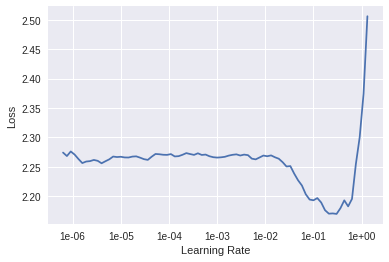

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze
learn.fit_one_cycle(1, slice(1e-2,6e-01), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.806973,1.771532,0.353432,01:09


In [0]:
learn.unfreeze
learn.fit_one_cycle(3, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.778611,1.784350,0.353432,01:09
1,1.768139,1.770453,0.353432,01:12
2,1.759822,1.770591,0.353432,01:09


In [0]:
learn2.save('first')

In [0]:
learn2.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.007007,0.968582,0.695187,06:11


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))



epoch,train_loss,valid_loss,accuracy,time
0,1.756482,1.769354,0.353432,02:05
1,1.719099,3.080589,0.351828,02:11
2,1.734871,2.763771,0.351187,02:12


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
!cp models -r drive

In [0]:
!cp *.pkl drive

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.711255,2.180521,0.364978,02:51
1,1.741922,2.685164,0.352790,02:44
2,1.716945,3.055881,0.361129,02:44


In [0]:
learn.save('final_az')

In [0]:
data_clas.train_ds.y.c2i

{'Credit card': 0,
 'Credit card ': 1,
 'Loan': 2,
 'Medical': 3,
 'Mobile or digital wallet': 4,
 'Payday loan': 5,
 'Virtual currency': 6,
 'money transfer': 7,
 'mortgage': 8}

In [0]:
data.valid_ds.y.items

array([ 4,  5, 11,  4, ...,  4,  6,  4,  4])

In [0]:
learn.predict(" regarding debt not verified, debt not belonging to me, have asked creditor to cease attempts to collect debt & to remove from my credit repo") 

(Category mortgage,
 tensor(8),
 tensor([0.1216, 0.1507, 0.0685, 0.2250, 0.0155, 0.0364, 0.0129, 0.0287, 0.3407]))

In [0]:
preds = learn.pred_batch()

In [0]:
type(preds), preds.shape

(torch.Tensor, torch.Size([16, 13]))

In [0]:
preds.dim()

2

In [0]:
probs = np.exp(preds)
probs

tensor([54.5982, 54.5982, 54.5982, 54.5982, 54.5982, 54.5982, 54.5982, 54.5982,
        54.5982, 54.5982, 54.5982, 54.5982, 54.5982, 54.5982, 54.5982, 54.5982],
       dtype=torch.float64)

In [0]:
learn.data.train_ds.x.items, learn.data.train_ds.y.items

(array([array([  2,   5,  15, 269,  18, 878,  13, 296,   9,  10, 338,  23, 270,  33,  15,  31, 381,   9]),
        array([   2,   13,  357,   47,  514,   35,   22, 1791]),
        array([   2,   13,   14,   34,   36,   16,    5,   11,    5,  113,    5, 1677,    9,   10,   21, 1973,   11,   34,
          36,   29,   78,   17,   11,  344,   22,   11,  141,   19,   10,   21,  458,   13]),
        array([   2,  946,    5,   60,   53,   14,  809,  363,   46,   17,   38,   39, 1016,    7,  224,  401,  558,   51,
          12,   11, 1253,   17,   68,   36,    9,  946,   64, 1427,   11,  284,   12,  158,   61,  925,   11,  284,
          12,  280,    0,   60, 1232]),
        ...,
        array([   2,    5,   20,   54,   11,  554,   30,  245,   12,   62, 1280,   11,  232,   30,   48,  256,    9,   10,
         130,   24,   79,   14,   30,  245,   76,   11,  180,  285,  157,   24,  201,  221,   11,   30,   28,  256,
           9,   10,   66,   24,   21,   14,  319, 1009]),
        array([   2,  

In [0]:
learn.model.eval()

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(8859, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(8859, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.27999999999999997)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e

In [0]:
obs = data.train_ds[640][0]
obs

Text xxbos and i said this : xxmaj commonwealth xxmaj financial xxmaj systems is violating xxup fcra by

In [0]:
learn.predict(obs)

(Category mortgage,
 tensor(8),
 tensor([0.1189, 0.1470, 0.0697, 0.2210, 0.0157, 0.0348, 0.0132, 0.0297, 0.3500]))

In [0]:
pred_class,pred_idx,outputs = learn.predict(obs)
pred_class,pred_idx,outputs

(Category mortgage,
 tensor(8),
 tensor([0.1189, 0.1470, 0.0697, 0.2210, 0.0157, 0.0348, 0.0132, 0.0297, 0.3500]))